In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from data_loader.load_data import ImagesLoader

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             ExtraTreesClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

In [34]:
DATASET_NAME = 'simpsons-large'
PIPELINE_NAME = [
    'images_gray',
    'images_resized',
    # 'images_blue',
    # 'images_green',
    # 'images_red',
    # 'descriptor_blue',
    # 'descriptor_green',
    # 'descriptor_red',
    # 'descriptor_rgb',
    'images_h',
    'images_s',
    'images_v',
    'descriptor_h',
    'descriptor_s',
    'descriptor_v',
    'descriptor_hsv'
    # 'combination_rgb+hsv'
]

# **CARREGANDO OS DADOS**

In [4]:
loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

data = loader.load_data(load_list=PIPELINE_NAME)

+ 'names_files' loaded
+ 'names_paths' loaded
+ 'names_characters' loaded
+ 'names_encoded' loaded
+ 'images_original' loaded
+ 'images_resized' loaded
+ 'images_gray' loaded
+ 'images_blue' loaded
+ 'images_green' loaded
+ 'images_red' loaded
- 'images_hsv' not in load list
+ 'images_h' loaded
+ 'images_s' loaded
+ 'images_v' loaded
- 'images_lbp' not in load list
- 'images_hu' not in load list
- 'images_gabor' not in load list
- 'images_hog' not in load list
+ 'descriptor_blue' loaded
+ 'descriptor_green' loaded
+ 'descriptor_red' loaded
+ 'descriptor_rgb' loaded
+ 'descriptor_h' loaded
+ 'descriptor_s' loaded
+ 'descriptor_v' loaded
+ 'descriptor_hsv' loaded
- 'descriptor_lbp' not in load list
- 'descriptor_hu' not in load list
- 'descriptor_gabor' not in load list
- 'descriptor_hog' not in load list
+ 'combination_rgb+hsv' loaded
- 'combination_rgb+hsv+lbp' not in load list
- 'combination_rgb+hsv+hu' not in load list
- 'combination_rgb+hsv+hog' not in load list
- 'combination_rgb+h

In [14]:
data['descriptor_hsv']['train'].shape

(0,)

In [21]:
print('names_characters')
print(np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape, end='\n\n')

print(PIPELINE_NAME[6])
print(np.array(data[PIPELINE_NAME[6]]['train']).shape,
      np.array(data[PIPELINE_NAME[6]]['test']).shape)

names_characters
(6571,) (96,)

descriptor_rgb
(6571, 768) (96, 768)


# **TRAIN-TEST SPLIT**

In [22]:
X_train = np.array(data[PIPELINE_NAME[6]]['train'])
y_train = np.array(data['names_encoded']['train'])

X_test = np.array(data[PIPELINE_NAME[6]]['test'])
y_test = np.array(data['names_encoded']['test'])

X_train.shape, X_test.shape

((6571, 768), (96, 768))

# **PIPELINE DE MODELOS**

In [23]:
models = {
    'knn': KNeighborsClassifier(),
    'nb': GaussianNB(),
    'lsvc': LinearSVC(),
    'svc': SVC(),
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'lgbm': LGBMClassifier(),
    'xgb': XGBClassifier(),
    'ab': AdaBoostClassifier(),
    'et': ExtraTreesClassifier(),
    'mlp': MLPClassifier(),
    'dc': DummyClassifier(strategy='stratified')
}

preds = {}
results = {}

In [24]:
# treinando e realizando as predições

for name, model in zip(list(models.keys()), list(models.values())):    
    pipe = Pipeline([
        ('scaler', MinMaxScaler(feature_range=(0,1))),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    preds[name] = y_pred
    results[name] = classification_report(y_test, y_pred, output_dict=True)
        
    print(name, 'completed')

knn completed
nb completed
lsvc completed
svc completed
lr completed
rf completed
lgbm completed
xgb completed
ab completed
et completed
mlp completed
dc completed


# **EXIBIÇÃO DOS RESULTADOS**

In [25]:
# criando um df de resultados dos modelos

for name, result, i in zip(list(results.keys()),
                           list(results.values()),
                           range(len(results))): 
    # df do classification report 
    df_report = pd.DataFrame(data=results[name]).T

    # dicionário para decodificar labels
    decoded_labels = {value: key for value, key in zip(list(loader.encoded_labels.values()),
                                                       list(loader.encoded_labels.keys()))}

    # decodificando labels
    df_report.index = list(map(lambda field: decoded_labels[int(field)] \
                               if field in np.array(list(loader.encoded_labels.values())).astype(str) \
                               else field, list(df_report.index)))

    # definindo index com o modelo
    arrays = [[name for i in range(9)], df_report.T.columns]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=['model', 'labels'])
    df_report.index = index

    # mesclando os df_reports
    if i == 0:
        df_results = df_report
    else:
        df_results = pd.concat([df_results, df_report], axis=0)

# df_results.replace({0: 'homer'})
df_results

precision    recall  f1-score    support
model labels                                                
knn   bart           0.600000  0.600000  0.600000  35.000000
      homer          0.428571  0.360000  0.391304  25.000000
      lisa           0.161290  0.384615  0.227273  13.000000
      marge          0.500000  0.100000  0.166667  10.000000
      maggie         1.000000  0.583333  0.736842  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.447917  0.447917  0.447917   0.447917
      macro avg      0.448310  0.337991  0.353681  96.000000
      weighted avg   0.529282  0.447917  0.460895  96.000000
nb    bart           0.416667  0.142857  0.212766  35.000000
      homer          0.200000  0.040000  0.066667  25.000000
      lisa           0.000000  0.000000  0.000000  13.000000
      marge          1.000000  0.100000  0.181818  10.000000
      maggie         0.136364  0.750000  0.230769  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.166667  0.166667  0.166667   0.166667
      macro avg      0.292172  0.172143  0.115337  96.000000
      weighted avg   0.325205  0.166667  0.142718  96.000000
lsvc  bart           0.666667  0.685714  0.676056  35.000000
      homer          0.527778  0.760000  0.622951  25.000000
      lisa           0.214286  0.230769  0.222222  13.000000
      marge          0.000000  0.000000  0.000000  10.000000
      maggie         1.000000  0.583333  0.736842  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.552083  0.552083  0.552083   0.552083
      macro avg      0.401455  0.376636  0.376345  96.000000
      weighted avg   0.534516  0.552083  0.530904  96.000000
svc   bart           0.677419  0.600000  0.636364  35.000000
      homer          0.391304  0.720000  0.507042  25.000000
      lisa           0.000000  0.000000  0.000000  13.000000
      marge          1.000000  0.100000  0.181818  10.000000
      maggie         1.000000  0.583333  0.736842  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.489583  0.489583  0.489583   0.489583
      macro avg      0.511454  0.333889  0.343678  96.000000
      weighted avg   0.578045  0.489583  0.475094  96.000000
lr    bart           0.583333  0.800000  0.674699  35.000000
      homer          0.620690  0.720000  0.666667  25.000000
      lisa           0.000000  0.000000  0.000000  13.000000
      marge          0.500000  0.100000  0.166667  10.000000
      maggie         1.000000  0.500000  0.666667  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.552083  0.552083  0.552083   0.552083
      macro avg      0.450670  0.353333  0.362450  96.000000
      weighted avg   0.551395  0.552083  0.520289  96.000000
rf    bart           0.432432  0.914286  0.587156  35.000000
      homer          0.555556  0.400000  0.465116  25.000000
      lisa           0.666667  0.153846  0.250000  13.000000
      marge          0.000000  0.000000  0.000000  10.000000
      maggie         1.000000  0.083333  0.153846  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.468750  0.468750  0.468750   0.468750
      macro avg      0.442442  0.258578  0.242686  96.000000
      weighted avg   0.517611  0.468750  0.388276  96.000000
lgbm  bart           0.523077  0.971429  0.680000  35.000000
      homer          0.791667  0.760000  0.775510  25.000000
      lisa           0.500000  0.153846  0.235294  13.000000
      marge          0.500000  0.100000  0.166667  10.000000
      maggie         1.000000  0.083333  0.153846  12.000000
      family         0.000000  0.000000  0.000000   1.000000
      accuracy       0.593750  0.593750  0.593750   0.593750
      macro avg      0.552457  0.344768  0.335220  96.000000
      weighted avg   0.641660  0.593750  0.518327  96.000000
xgb   bart           0.548387  0.971429  0.701031  35.0

In [16]:
# # salvar resultados?
# df_results.to_csv(f'../output/pipeline_{PIPELINE_NAME}_results.csv')

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).

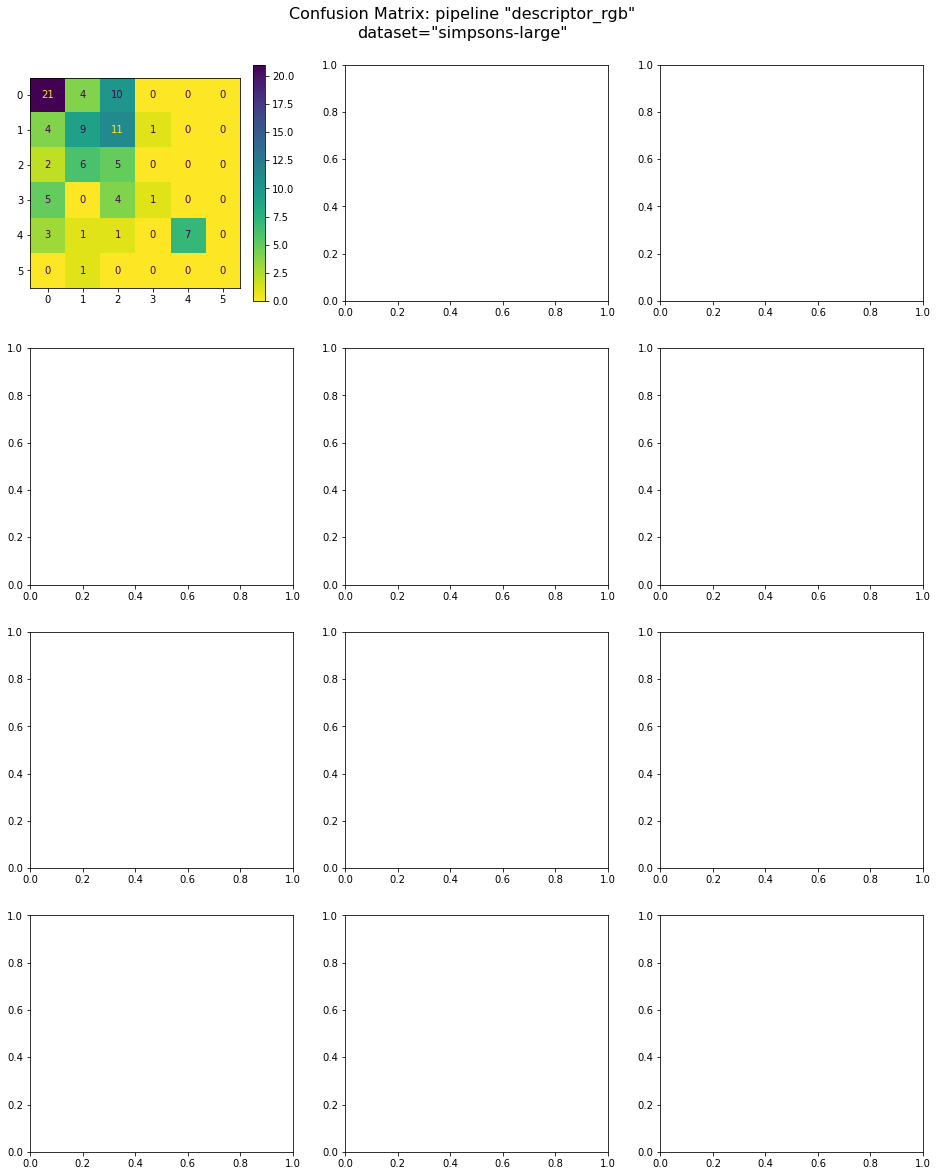

In [29]:
# exibindo a matriz de confusão dos modelos

fig, ax = plt.subplots(4,3, figsize=(16,20))

fig.text(x=.5,
         y=.92,
         s=f'Confusion Matrix: pipeline "{PIPELINE_NAME[6]}"\ndataset="{DATASET_NAME}"',
         horizontalalignment='center',
         verticalalignment='top',
         fontsize=16)

for name, pred, i in zip(list(preds.keys()),
                         list(preds.values()),
                         range(len(preds))):
    
    cm = confusion_matrix(y_test, pred)
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
    cm_plot.plot(cmap='viridis_r', ax=ax.ravel()[i]);
    cm_plot.im_.colorbar.remove()

    ax.ravel()[i].set_title(f"{name}; accuracy = " \
                            f"{round(results[name]['accuracy'], 2)}; " \
                            f"weight f1 = " \
                            f"{round(results[name]['weighted avg']['f1-score'], 2)}");

# plt.savefig(f'../images/pipeline_{PIPELINE_NAME}_cm.jpg')